In [2]:
%config IPCompleter.greedy=True

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

In [4]:
ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/movies.csv')
tags_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/tags.csv')
links_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/links.csv')

In [5]:
'''ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/movies.csv')'''

"ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/ratings.csv')\nmovies_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/movies.csv')"

# Dataset

In [6]:
'''percentage = 3
movies_df = movies_df.head(int(len(movies_df)*(percentage/100)))'''

'percentage = 3\nmovies_df = movies_df.head(int(len(movies_df)*(percentage/100)))'

In [7]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [8]:
#ratings_df = ratings_df.head(int(len(ratings_df)*(percentage/100)))

In [9]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [10]:
#ratings_df.columns = ['userId', 'movieId', 'rating', 'timestamp']

In [11]:
num_users = ratings_df['userId'].unique()
print(len(num_users))
num_items = ratings_df['movieId'].unique()
print(len(num_items))

610
9724


# Spotlight

## Data preperation for Spotlight

The ids are not consecutive. For examples the id of a movies is shown multiple times. For this reason the procedure below is implemented. The reversed map is still saved to be used when needed.

In [12]:
from collections import defaultdict
from itertools import count
uid_map = defaultdict(count().__next__)
iid_map = defaultdict(count().__next__)
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %d got uid %d" % (556, uid_map[556]))
print("movieId %d got iid %d" % (54001, iid_map[54001]))

userId 556 got uid 555
movieId 54001 got iid 2518


In [13]:
len(uid_rev_map)

610

Create the dataset variable representing the dataset prepared for use to create a recommendation systems using the Spotlight platform.

## Implicit Factorization model

In [14]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  


#pecify the ids of the users and items for all the pairs of user-item interactions
implicit_interaction = Interactions(user_ids=uids,
                                   item_ids=iids,
                                   timestamps = timestamps)


#lets initialise the seed, so that its repeatable and reproducible 
implicit_train_tmp, implicit_test = random_train_test_split(implicit_interaction, random_state=np.random.seed(42))
implicit_train, implicit_val = random_train_test_split(implicit_train_tmp, random_state=np.random.seed(42))
implicit_train_features, implicit_train_labels = random_train_test_split(implicit_train, random_state=np.random.seed(42))

In [15]:
print(implicit_train)
print(implicit_test)
print(implicit_val)
print(implicit_train_features)
print(implicit_train_labels)

<Interactions dataset (610 users x 9724 items x 64534 interactions)>
<Interactions dataset (610 users x 9724 items x 20168 interactions)>
<Interactions dataset (610 users x 9724 items x 16134 interactions)>
<Interactions dataset (610 users x 9724 items x 51627 interactions)>
<Interactions dataset (610 users x 9724 items x 12907 interactions)>


### Train-test split to DataFrame

Train and test interaction datasets are converted to dataframes, in order to be used from other models too and provide consistent and fair results.

In [16]:
def interactionToDataFrame(dataset):
    converted_users = []
    converted_movies = []
    rating = []
    for i in range(len(dataset.user_ids)):
        converted_users.append(uid_rev_map[dataset.user_ids[i]])
        converted_movies.append(iid_rev_map[dataset.item_ids[i]])
        rating.append(float(ratings_df['rating'][(ratings_df['movieId'] == converted_movies[i]) & (
            ratings_df['userId'] == converted_users[i])].values))

    df = pd.DataFrame({'user_id': converted_users,
                       'movie_id': converted_movies, 'rating': rating})
    return df

In [17]:
train_df = interactionToDataFrame(implicit_train)
val_df = interactionToDataFrame(implicit_val)
test_df = interactionToDataFrame(implicit_test)
train_features_df = interactionToDataFrame(implicit_train_features)
train_labels_df = interactionToDataFrame(implicit_train_labels)

### Pickle 

Save

In [18]:
'''train_df.to_pickle("./train_df.pkl")
test_df.to_pickle("./test_df.pkl")
val_df.to_pickle("./val_df.pkl")'''

'train_df.to_pickle("./train_df.pkl")\ntest_df.to_pickle("./test_df.pkl")\nval_df.to_pickle("./val_df.pkl")'

Load

In [19]:
'''train_df = pd.read_pickle("./train_df.pkl")
test_df = pd.read_pickle("./test_df.pkl")
val_df = pd.read_pickle("./val_df.pkl")'''

'train_df = pd.read_pickle("./train_df.pkl")\ntest_df = pd.read_pickle("./test_df.pkl")\nval_df = pd.read_pickle("./val_df.pkl")'

### Train Implicit Factorization model 

In [20]:
implicit_model = ImplicitFactorizationModel(n_iter=5)

current = time.time()

implicit_model.fit(implicit_train, verbose=True)

end = time.time()
diff = end - current
print('Training took %d second' % (diff))

Epoch 0: loss 0.7535633839401803
Epoch 1: loss 0.446343260320279
Epoch 2: loss 0.4027594837982193
Epoch 3: loss 0.36152724951152276
Epoch 4: loss 0.3278165670487249
Training took 31 second


### MRR score

In [21]:
from spotlight.evaluation import mrr_score
print(mrr_score(implicit_model, implicit_test, train=implicit_train, k=100).mean())

0.2549135749655387


Distribution of scores for a user

(array([   6.,   21.,   76.,  209.,  601., 1105., 1425., 1317.,  955.,
         559.,  399.,  305.,  242.,  191.,  168.,  139.,  139.,  136.,
         131.,  130.,  108.,  110.,   99.,  128.,  109.,  109.,   89.,
         103.,   92.,  103.,   91.,   93.,   69.,   48.,   40.,   28.,
          21.,   17.,   10.,    3.]),
 array([-11.941548  , -11.307965  , -10.674382  , -10.0408    ,
         -9.407217  ,  -8.773634  ,  -8.140051  ,  -7.5064683 ,
         -6.8728857 ,  -6.2393026 ,  -5.6057196 ,  -4.972137  ,
         -4.338554  ,  -3.7049713 ,  -3.0713885 ,  -2.4378057 ,
         -1.8042227 ,  -1.1706399 ,  -0.537057  ,   0.09652589,
          0.73010874,   1.3636916 ,   1.9972744 ,   2.6308572 ,
          3.26444   ,   3.8980231 ,   4.5316057 ,   5.165189  ,
          5.7987714 ,   6.4323545 ,   7.065937  ,   7.69952   ,
          8.333103  ,   8.966686  ,   9.600268  ,  10.233851  ,
         10.8674345 ,  11.501018  ,  12.1346    ,  12.768183  ,
         13.401766  ], dtype=float32),

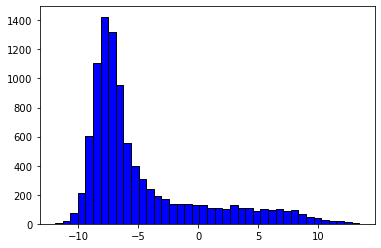

In [22]:
plt.hist(implicit_model.predict(0), color = 'blue', edgecolor = 'black',
         bins = 40)

Not a lot items with high score

### Top-K predictions for a user

In [23]:
import scipy.stats as st
k = 100
def topK_implicit(user, model, k=100):
  a= list()
  ranks = st.rankdata(-model.predict(user))   
  for iid in np.argwhere(ranks <= k):
    #print(iid_rev_map[iid.item(0)])
    a.append(iid_rev_map[iid.item(0)])
  return a

rec_forUser = topK_implicit(0,implicit_model)
print(rec_forUser)

[1, 6, 47, 50, 110, 163, 223, 231, 235, 260, 296, 316, 349, 356, 367, 457, 480, 500, 527, 552, 590, 592, 593, 608, 648, 733, 736, 780, 1073, 1097, 1136, 1197, 1210, 1240, 1265, 1517, 2028, 318, 32, 342, 357, 368, 539, 588, 595, 2762, 34, 39, 150, 153, 253, 266, 300, 344, 364, 380, 410, 589, 597, 2, 10, 11, 19, 62, 104, 112, 141, 160, 161, 165, 168, 185, 196, 208, 282, 288, 292, 293, 315, 317, 329, 337, 339, 350, 377, 440, 485, 524, 587, 586, 529, 1221, 442, 555, 173, 420, 551, 743, 788, 2124]


The function below (allUsers_topK_implicit) returns a list that contains the top-K recommendations for each user.

In [24]:
def allUsers_topK_implicit(model):
    a = []
    for i in range(len(num_users)):
       a.append(topK_implicit(i,model))
    return a

In [25]:
movies_df.loc[movies_df['movieId'].isin(rec_forUser)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
5,6,Heat (1995),Action|Crime|Thriller
9,10,GoldenEye (1995),Action|Adventure|Thriller
10,11,"American President, The (1995)",Comedy|Drama|Romance
...,...,...,...
964,1265,Groundhog Day (1993),Comedy|Fantasy|Romance
1154,1517,Austin Powers: International Man of Mystery (1...,Action|Adventure|Comedy
1503,2028,Saving Private Ryan (1998),Action|Drama|War
1585,2124,"Addams Family, The (1991)",Children|Comedy|Fantasy


In [26]:
movies_pred = movies_df['movieId'][movies_df['movieId'].isin(rec_forUser)]

### Μovies watched from a user

In [27]:
actual = ratings_df[ratings_df["userId"]==uid_rev_map.get(0)].groupby("movieId")["movieId"].count().sort_values(ascending=False).head(100)

In [28]:
actual = actual.index.tolist()

In [29]:
movies_df.loc[movies_df['movieId'].isin(actual)]

,movieId,title,genres
2,3,Grumpier Old Men (1995),Comedy|Romance
5,6,Heat (1995),Action|Crime|Thriller
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
62,70,From Dusk Till Dawn (1996),Action|Comedy|Horror|Thriller
...,...,...,...
1332,1804,"Newton Boys, The (1998)",Crime|Drama
1333,1805,Wild Things (1998),Crime|Drama|Mystery|Thriller
1401,1920,Small Soldiers (1998),Animation|Children|Fantasy|War
2991,4006,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi


In [30]:
movies_watched = movies_df['movieId'][movies_df['movieId'].isin(actual)]

### NDCG Score

In [31]:
allUsers_topK_imp = allUsers_topK_implicit(implicit_model)

In [32]:
rec_forUser == allUsers_topK_imp[0]

True

In [33]:
relevance_implicit = []
for i in range(len(rec_forUser)):
    if rec_forUser[i] in test_df['movie_id'][test_df['user_id'] == 1].values.tolist():
        relevance_implicit.append(1)
    else:
        relevance_implicit.append(0)
    

Compute the relevance for each user. The relevance containes 0s and 1s based on which movies each has watched. For every recommended movie that the user has actually watched, the value of 1 is assigned. There is a relevance list for each user.

In [34]:
def relevance_spotlight_implicit(allUsers_topK):
    relevance_implicit_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(allUsers_topK[count])):
            if allUsers_topK[count][j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_implicit_full.append(helper)
        helper = []
        count += 1
    return relevance_implicit_full

In [35]:
relevance_implicit_full = relevance_spotlight_implicit(allUsers_topK_imp)

In [36]:
relevance_implicit == relevance_implicit_full[0]

True

The dcg and ideal_dcg functions are taken form https://github.com/lezzago/LambdaMart/blob/master/lambdamart.py. They are necessary to compute the desired NDCG evaluation metric.

In [37]:
def dcg(scores):
    """
    Returns the DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    DCG_val: int
        This is the value of the DCG on the given scores
    """
    return np.sum([
                    (np.power(2, scores[i]) - 1) / np.log2(i + 2)
                    for i in range(len(scores))
                ])

In [38]:
def ideal_dcg(scores):
    """
    Returns the Ideal DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    Ideal_DCG_val: int
        This is the value of the Ideal DCG on the given scores
    """
    scores = [score for score in sorted(scores)[::-1]]
    return dcg(scores)

In [39]:
def NDCG_forUser(relevance):
    return dcg(relevance) / ideal_dcg(relevance)

In [40]:
ndcg = NDCG_forUser(relevance_implicit_full[0])
print(ndcg)
ndcg = NDCG_forUser(relevance_implicit)
print(ndcg)

0.8236762566541531
0.8236762566541531


Creation of a list (allUsers_implicit_ndcg) that contains the NDCG score for each user.

In [41]:
def allUsers_ndcg(relevance):
    allUsers_implicit_ndcg = []
    for i in range(len(num_users)):
        allUsers_implicit_ndcg.append(NDCG_forUser(relevance[i]))
    return allUsers_implicit_ndcg

In [42]:
allUsers_implicit_ndcg = allUsers_ndcg(relevance_implicit_full)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


Fill the nan values with 0s.

In [43]:
allUsers_implicit_ndcg = pd.Series(allUsers_implicit_ndcg).fillna(0).tolist()

## Implicit Sequence model

In [44]:
from spotlight.sequence.implicit import ImplicitSequenceModel
from spotlight.evaluation import sequence_mrr_score
from spotlight.sequence.implicit import ImplicitSequenceModel

### Train Implicit Sequence model

In [46]:
'''sequence_model  = ImplicitSequenceModel(n_iter = 5)

current = time.time()
sequence_model.fit(interactions = implicit_train.to_sequence(),verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))'''

"sequence_model  = ImplicitSequenceModel(n_iter = 5)\n\ncurrent = time.time()\nsequence_model.fit(interactions = implicit_train.to_sequence(),verbose = True)\n\nend = time.time()\ndiff = end - current\nprint('Training took %d second'%(diff))"

In [47]:
#sequence_model.predict(sequences = 9724)

### MRR Score

In [48]:
#print(sequence_mrr_score(sequence_model, implicit_test.to_sequence()).mean())

### Top-K predictions for a user

In [49]:
#allUsers_topK_sequence = allUsers_topK_implicit(sequence_model)

### NDCG Score

In [50]:
#relevance_sequence_full = relevance_spotlight_implicit(allUsers_topK_sequence)

In [51]:
#allUsers_sequence_ndcg = allUsers_ndcg(relevance_sequence_full)

In [52]:
#allUsers_sequence_ndcg = pd.Series(allUsers_sequence_ndcg).fillna(0).tolist()

# SVD

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [53]:
df_movie_features = train_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [54]:
df_movie_features

movie_id,1,2,3,4,5,6,7,8,9,10,...,190209,190219,190221,193565,193567,193571,193581,193583,193585,193587
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## SVD implementation

In [55]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(df_movie_features, k = 10)

## Predictions

To get the prediction of a rating of an item dj, we can calculate the dot product of the two vectors.
The sigma variable has just the values, so I have to convert to a diagonal matrix in orded to implement the matrix multiplication.

In [56]:
sigma = np.diag(sigma)
svd_predictions_score = np.dot(np.dot(U, sigma), Vt)
svd_predictions_score_df = pd.DataFrame(svd_predictions_score, columns = df_movie_features.columns)


In [57]:
svd_predictions_score[1]

array([ 0.063084  ,  0.01766658, -0.07025156, ...,  0.00437932,
        0.00437932,  0.00437932])

In [58]:
svd_predictions_score_df

movie_id,1,2,3,4,5,6,7,8,9,10,...,190209,190219,190221,193565,193567,193571,193581,193583,193585,193587
0,1.688708,0.458426,0.393726,0.011205,0.115494,1.167295,-0.046513,0.005338,0.037091,1.095148,...,-0.000853,-0.000213,-0.000213,-0.008988,-0.007704,-0.010272,-0.010272,-0.008988,-0.008988,-0.008988
1,0.063084,0.017667,-0.070252,-0.005869,-0.011273,0.023740,-0.041345,-0.020815,0.003521,-0.087446,...,0.001623,0.000406,0.000406,0.004379,0.003754,0.005005,0.005005,0.004379,0.004379,0.004379
2,0.033224,0.019811,0.014590,-0.000669,-0.008589,0.058930,-0.015279,0.001663,0.001220,0.057268,...,-0.000466,-0.000116,-0.000116,-0.000373,-0.000320,-0.000426,-0.000426,-0.000373,-0.000373,-0.000373
3,0.917798,0.235219,0.183208,0.039929,0.128628,0.539320,0.129805,-0.057966,0.003938,0.333317,...,0.000828,0.000207,0.000207,-0.001962,-0.001682,-0.002243,-0.002243,-0.001962,-0.001962,-0.001962
4,0.791287,0.681703,0.258285,0.060598,0.254623,0.487621,0.429986,0.107012,0.020321,0.632953,...,0.002094,0.000524,0.000524,-0.000531,-0.000455,-0.000607,-0.000607,-0.000531,-0.000531,-0.000531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,1.554904,1.550197,0.307605,0.255871,0.548586,-0.240734,1.260181,0.056290,-0.169419,0.417293,...,0.000728,0.000182,0.000182,-0.000066,-0.000056,-0.000075,-0.000075,-0.000066,-0.000066,-0.000066
606,1.482410,0.603201,0.379869,0.032845,0.227519,0.942603,0.193504,0.050515,0.026183,0.981710,...,0.000420,0.000105,0.000105,-0.006020,-0.005160,-0.006881,-0.006881,-0.006020,-0.006020,-0.006020
607,2.786608,0.954572,1.344043,-0.018435,0.510436,2.090074,0.345955,0.444181,0.152362,2.645235,...,0.002744,0.000686,0.000686,-0.031944,-0.027380,-0.036507,-0.036507,-0.031944,-0.031944,-0.031944
608,0.714217,0.549229,0.203728,0.045918,0.205905,0.465570,0.354462,0.090467,0.021644,0.540067,...,0.002947,0.000737,0.000737,-0.000037,-0.000032,-0.000042,-0.000042,-0.000037,-0.000037,-0.000037


In [59]:
svd_predictions_score_df[svd_predictions_score_df.index == 609]

movie_id,1,2,3,4,5,6,7,8,9,10,...,190209,190219,190221,193565,193567,193571,193581,193583,193585,193587
609,0.1835,1.701411,-0.571403,-0.059711,-1.281285,3.737838,-0.382591,0.392249,0.100501,2.232688,...,0.008994,0.002248,0.002248,0.030138,0.025833,0.034444,0.034444,0.030138,0.030138,0.030138


## Top-K recommendations

### First

The function below returns a list that contains the top-100 recommendations for each user

In [60]:
def SVD_topK_first(score_df):
    topK_svd_rec = []
    for i in range(len(num_users)):
        svd_h_df = pd.DataFrame({'movie_id': score_df[score_df.index == i].columns,
                                 'score': score_df[score_df.index == i].values[0]})
        svd_h_df = svd_h_df.sort_values('score', ascending=False)
        svd_h_df = svd_h_df.head(100)
        topK_svd_rec.append(svd_h_df['movie_id'].values)
    return topK_svd_rec

#### NDCG Score

The function below returns the relevance list of a list of movies.

In [61]:
def SVD_relevance_first(score_df):
    svd_topK = SVD_topK_first(score_df)
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count][j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full

In [62]:
relevance_first = SVD_relevance_first(svd_predictions_score_df)

In [63]:
np.asarray(relevance_first).shape

(610, 100)

In [64]:
n_f = NDCG_forUser(relevance_first[0])

In [65]:
n_f

0.6193708271879289

Below is the NDCG scores of each user

In [66]:
all_ndcg_f = allUsers_ndcg(relevance_first)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [67]:
all_ndcg_f = pd.Series(all_ndcg_f).fillna(0).tolist()

In [68]:
np.asarray(all_ndcg_f).mean()

0.3854555522461128

### Second

Code used from https://github.com/nikitaa30/Recommender-Systems/blob/master/matrix_factorisation_svd.py

Provide top-K predictions for a user

In [69]:
'''def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',
               right_on = 'movie_id').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations'''

"def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations):\n    # Get and sort the user's predictions\n    user_row_number = userID - 1 # UserID starts at 1, not 0\n    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1\n    \n    # Get the user's data and merge in the movie information.\n    user_data = original_ratings_df[original_ratings_df.userId == (userID)]\n    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').\n                     sort_values(['rating'], ascending=False)\n                 )\n    # Recommend the highest predicted rating movies that the user hasn't seen yet.\n    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',\n               right_on = 'movie_id').rename(columns = {user_row_number: 'Predictions'}).sort

In [70]:
'''already_rated, predictions = recommend_movies(svd_predictions_score_df, 1, movies_df, ratings_df, 100)
predictions.head()'''

'already_rated, predictions = recommend_movies(svd_predictions_score_df, 1, movies_df, ratings_df, 100)\npredictions.head()'

The function SVD_topK_allUsers returens a list that contains the top-K recommendations for each user.

In [71]:
'''def SVD_topK_allUsers():
    allUsers_already_rated = []
    allUsers_predictions = []
    for i in range(1,len(num_users)+1):
        already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
        allUsers_already_rated.append(already_rated)
        allUsers_predictions.append(predictions)
    return allUsers_predictions'''

'def SVD_topK_allUsers():\n    allUsers_already_rated = []\n    allUsers_predictions = []\n    for i in range(1,len(num_users)+1):\n        already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)\n        allUsers_already_rated.append(already_rated)\n        allUsers_predictions.append(predictions)\n    return allUsers_predictions'

#### NDCG Score

The function SVD_relevance returns a list that contains the relevance (0s and 1s) between the top-K recommendations and the movies that each user actually watched.

In [72]:
'''def SVD_relevance():
    svd_topK = SVD_topK_allUsers()
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count]['movieId'].values[j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full'''

"def SVD_relevance():\n    svd_topK = SVD_topK_allUsers()\n    relevance_svd_full = []\n    helper = []\n    count = 0\n    for i in range(1,len(num_users)+1):\n        for j in range(len(svd_topK[count])):\n            if svd_topK[count]['movieId'].values[j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():\n                helper.append(1)\n            else:\n                helper.append(0)\n        relevance_svd_full.append(helper)\n        helper = []\n        count += 1\n    return relevance_svd_full"

In [73]:
#svd_relevance = SVD_relevance()

In [74]:
#allUsers_svd_ndcg = allUsers_ndcg(svd_relevance)

# LightGBM Baseline

I create 2 features, which are the scores from the Implicit and SVD models on the top-K recommendations for each user based on the implicit model.

In [75]:
#target_movies = allUsers_topK_imp
#for i in range(len(num_users)):
#    target_movies.append(topK_implicit(i,implicit_model))

##  Feature 1 (Implicit factorization model scores)

Train an implicit factorization model using the train_features dataset

In [76]:
f1_model = ImplicitFactorizationModel(n_iter = 5)

current = time.time()

f1_model.fit(implicit_train_features,verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))

Epoch 0: loss 0.8157642548627192
Epoch 1: loss 0.45863076129762254
Epoch 2: loss 0.40242801916481247
Epoch 3: loss 0.3588606340460258
Epoch 4: loss 0.3150418759277551
Training took 22 second


In [77]:
allUsers_topK_f1 = allUsers_topK_implicit(f1_model)
target_movies = allUsers_topK_f1

Map the target movies to pick the correct predictions based on the item id

In [78]:
map_target_movies = []
map_help = []
for movies in target_movies:
    for movie in movies:
        map_help.append(iid_map[movie])
    map_target_movies.append(map_help)
    map_help = []

Implicit Factorization model Scores

Train implicit on implicit_features_train! and take these scores.

In [79]:
implicit_scores = 0
feature1 = []
for i in range(len(num_users)):
    #for movies in map_target_movies:
    my_list = map_target_movies[i]
    my_array = np.array(my_list)
    implicit_scores = f1_model.predict(user_ids = i,item_ids = my_array)
    feature1.append(implicit_scores)

In [80]:
feature1 = np.asarray(feature1)
feature1.shape

(610, 100)

In [81]:
#feature1 = np.asarray(feature1).reshape(len(num_users),100)

## Feature 2 (Implicit sequence model scores)

In [82]:
'''f2_model = ImplicitSequenceModel(n_iter = 5)

current = time.time()

f2_model.fit(implicit_train_features.to_sequence(),verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))'''

"f2_model = ImplicitSequenceModel(n_iter = 5)\n\ncurrent = time.time()\n\nf2_model.fit(implicit_train_features.to_sequence(),verbose = True)\n\nend = time.time()\ndiff = end - current\nprint('Training took %d second'%(diff))"

In [83]:
'''implicit_scores = 0
feature2 = []
for i in range(len(num_users)):
    #for movies in map_target_movies:
    my_list = map_target_movies[i]
    my_array = np.array(my_list)
    implicit_scores = f2_model.predict(i,item_ids = my_array)
    feature2.append(implicit_scores)'''

'implicit_scores = 0\nfeature2 = []\nfor i in range(len(num_users)):\n    #for movies in map_target_movies:\n    my_list = map_target_movies[i]\n    my_array = np.array(my_list)\n    implicit_scores = f2_model.predict(i,item_ids = my_array)\n    feature2.append(implicit_scores)'

## Feature 3 (SVD scores)

SVD model Scores. Take advantage of the DataFrame containing the scores to extract the predicted scores for the desired movies.

In [84]:
df_movie_features1 = train_features_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [85]:
U1, sigma1, Vt1 = svds(df_movie_features1)
sigma1 = np.diag(sigma1)
svd_predictions_score1 = np.dot(np.dot(U1, sigma1), Vt1)
svd_predictions_score_df1 = pd.DataFrame(svd_predictions_score1, columns = df_movie_features1.columns)

In [86]:
target_movies[0][2]

50

In [87]:
svd_predictions_score_df1[svd_predictions_score_df1.index == 0]

movie_id,1,2,3,4,5,6,7,8,9,10,...,190209,190219,190221,193565,193567,193571,193581,193583,193585,193587
0,1.257308,0.532167,0.410764,0.044059,0.253674,1.123589,0.219466,0.035831,0.072019,1.008659,...,0.001029,0.000257,0.000257,-0.006209,-0.005322,-0.007096,-0.007096,-0.006209,-0.006209,-0.006209


In [88]:
float(svd_predictions_score_df1[svd_predictions_score_df1.index == 0][target_movies[0][0]].values)

1.257308422073934

In [89]:
feature3 = []
feature3_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        feature3_user.append(float(svd_predictions_score_df1[svd_predictions_score_df1.index == i][target_movies[i][j]].values))
    feature3.append(feature3_user)
    feature3_user = []

In [90]:
type(feature3)

list

## Feature 4 (Genre)

In [91]:
genres = []
genre_per_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a =  movies_df[movies_df['movieId'] == target_movies[i][j]]['genres']
        a = a.tolist()
        a = str(a[0])
        a = a.split('|')
        if 'Comedy' in a:
            genre_per_user.append(1)
        else:
            genre_per_user.append(0)
    genres.append(genre_per_user)
    genre_per_user = []

In [92]:
feature4 = genres

## Feature 5 (#Users watched each target movie)

In [93]:
number_views = []
number_view_per_movie = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['movieId'] == target_movies[i][j]]['userId'])
        number_view_per_movie.append(a)
    number_views.append(number_view_per_movie)
    number_view_per_movie = []


In [94]:
feature5 = number_views

## Feature 6 (New user)

In [95]:
len(ratings_df[ratings_df['userId']==1]) > 10

True

In [96]:
new_users_binary = []
binary_per_user = []
for i in range(len(num_users)):
    for j in range(len(target_movies[i])):
        a = len(ratings_df[ratings_df['userId']==1]) > 10
        if a:
            binary_per_user.append(1)
        else:
            binary_per_user.append(0)
    new_users_binary.append(binary_per_user)
    binary_per_user = []

In [97]:
feature6 = new_users_binary

## Features stack

In [98]:
features = np.stack((feature1,feature3,feature4,feature5))

## Labels

Below are the movies that each user watched

In [99]:
def watched_movies(df):
    watched = []
    for i in range(len(num_users)):
        watched.append(df[df["user_id"]==uid_rev_map.get(i)].groupby("movie_id")["movie_id"].count().index)  
    return watched

In [100]:
#train_labels_df
#test_df
#val_df
train_watched = watched_movies(train_labels_df)
test_watched = watched_movies(test_df)
val_watched = watched_movies(val_df)

Creation of the target list. It containes 0s and 1s for the 100 recommended movies for each user. Based on the watched movies it assigns the values. If the user watched the recommended movie, then the value of the target is equal to 1, otherwise it is 0.

In [101]:
def create_target(watched):
    user_target = []
    target = []
    for i in range(len(num_users)):
        for target_movie in target_movies[i]:
            if target_movie in watched[i]:
                user_target.append(1)
            else:
                user_target.append(0)
        target.append(user_target)
        user_target = []
    return target

In [102]:
label_train = create_target(train_watched)
label_test = create_target(test_watched)
label_val = create_target(val_watched)
#y_train = y_test = y_val

## LightGBM model

In [103]:
X = np.array(features)
label_train = np.array(label_train)
label_test = np.array(label_test)
label_val = np.array(label_val)

In [104]:
X = X.reshape(len(num_users)*k, len(features))
y_train = label_train.reshape(len(num_users)*k,)
y_test = label_test.reshape(len(num_users)*k,)
y_val = label_val.reshape(len(num_users)*k,)

In [139]:
import lightgbm as lgb
gbm = lgb.LGBMRanker(min_child_samples=1, learning_rate=.1, n_jobs=2, importance_type='gain',
                     num_leaves=31, min_child_weight=100)

target movies
train_df
feature1
feature2

In [132]:
'''X_train_feature1 = []
X_train_feature2 = []
for j in range(610):
    for i in range(len(target_movies[j])):
        if target_movies[j][i] in val_df['movie_id'].values.tolist():
            X_train_feature1.append(feature1[i])
            X_train_feature2.append(feature2[i])
print(X_train_feature1)
print(X_train_feature2)
#X_train = np.stack(X_train_feature1,X_train_feature2)'''

"X_train_feature1 = []\nX_train_feature2 = []\nfor j in range(610):\n    for i in range(len(target_movies[j])):\n        if target_movies[j][i] in val_df['movie_id'].values.tolist():\n            X_train_feature1.append(feature1[i])\n            X_train_feature2.append(feature2[i])\nprint(X_train_feature1)\nprint(X_train_feature2)\n#X_train = np.stack(X_train_feature1,X_train_feature2)"

X_train
X_test
X_val
y_train
y_test
y_val

In [133]:
X_train = X
X_test = X
X_val = X

In [134]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [135]:
query_train = [X_train.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test.shape[0]]
group_train = []
group_val = []
print(query_train)
print(query_val)
print(query_test)
'''
for i in range(390):
    group_train.append(100)
group_train.append(40)
group_val.append(60)
for i in range(97):
    group_val.append(100)'''

for i in range(len(num_users)):
    group_train.append(k)
    group_val.append(k)


[61000]
[61000]
[61000]


In [140]:
gbm.fit(X_train, y_train, group=group_train,
        eval_set=[(X_val, y_val)], eval_group=[group_val],
        eval_at=[1, 3, 5, 10], early_stopping_rounds=50, eval_metric='ndcg')

[1]	valid_0's ndcg@1: 0.17541	valid_0's ndcg@3: 0.184578	valid_0's ndcg@5: 0.193217	valid_0's ndcg@10: 0.210163
Training until validation scores don't improve for 50 rounds
[2]	valid_0's ndcg@1: 0.183607	valid_0's ndcg@3: 0.182567	valid_0's ndcg@5: 0.187235	valid_0's ndcg@10: 0.208614
[3]	valid_0's ndcg@1: 0.172131	valid_0's ndcg@3: 0.173283	valid_0's ndcg@5: 0.175895	valid_0's ndcg@10: 0.191377
[4]	valid_0's ndcg@1: 0.155738	valid_0's ndcg@3: 0.167027	valid_0's ndcg@5: 0.173117	valid_0's ndcg@10: 0.187346
[5]	valid_0's ndcg@1: 0.157377	valid_0's ndcg@3: 0.17062	valid_0's ndcg@5: 0.177889	valid_0's ndcg@10: 0.191415
[6]	valid_0's ndcg@1: 0.191803	valid_0's ndcg@3: 0.18613	valid_0's ndcg@5: 0.188332	valid_0's ndcg@10: 0.201101
[7]	valid_0's ndcg@1: 0.159016	valid_0's ndcg@3: 0.168716	valid_0's ndcg@5: 0.176002	valid_0's ndcg@10: 0.195785
[8]	valid_0's ndcg@1: 0.157377	valid_0's ndcg@3: 0.165172	valid_0's ndcg@5: 0.171462	valid_0's ndcg@10: 0.190405
[9]	valid_0's ndcg@1: 0.155738	valid_0

LGBMRanker(importance_type='gain', min_child_samples=1, min_child_weight=100,
           n_jobs=2)

In [141]:
test_pred = gbm.predict(X_test)
test_pred

array([-0.00916072, -0.00916072, -0.00916072, ..., -0.00916072,
        0.0079397 ,  0.0079397 ])

## NDCG Score

In [142]:
p = 0
m = 100
lgbm_pred_per_user = []
for i in range(len(num_users)):
    lgbm_pred_per_user.append(test_pred[p:m])
    p += 100
    m += 100

### NDCG IFM on this data

In [143]:
lgbm_NDCG = []
IFM_NDCG = []
SVD_NDCG = []
for i in range(len(num_users)):    
    excel_df = pd.DataFrame({'movie_id': target_movies[i],'model1_score':feature1[i], 'model2_score':feature3[i],
                             'is_comedy':feature4[i], '#users_watched':feature5[i], 
                             'train_label':label_train[i], 'test_label':label_test[i],
                            'y_val':label_val[i],'LGBM Score':lgbm_pred_per_user[i]})
    excel_df = excel_df.sort_values('LGBM Score',ascending = False)
    relevance_lgbm_user = excel_df['test_label'].values.tolist()
    lgbm_NDCG.append(NDCG_forUser(relevance_lgbm_user))
    excel_df = excel_df.sort_values('model1_score',ascending = False)
    ifm_relevance = excel_df['test_label'].values.tolist()
    IFM_NDCG.append(NDCG_forUser(ifm_relevance))
    excel_df = excel_df.sort_values('model2_score',ascending = False)
    svd_relevance_h = excel_df['test_label'].values.tolist()
    SVD_NDCG.append(NDCG_forUser(svd_relevance_h))

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [144]:
lgbm_NDCG = pd.Series(lgbm_NDCG).fillna(0).tolist()
IFM_NDCG = pd.Series(IFM_NDCG).fillna(0).tolist()
SVD_NDCG = pd.Series(SVD_NDCG).fillna(0).tolist()

## Excel-Like

In [145]:
excel1_df = pd.DataFrame({'movie_id': target_movies[0],'model1_score':feature1[0], 'model2_score':feature3[0],'is_comedy':feature4[0],
                            '#users_watched':feature5[0], 'train_label':label_train[0], 'test_label':label_test[0],
                            'label_val':label_val[0],'LGBM Score':lgbm_pred_per_user[0]})

In [146]:
excel1_df.head(10)

,movie_id,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
0,1,14.507486,1.257308,1,215,0,1,0,-0.009161
1,47,13.880718,1.279574,0,203,0,1,0,-0.009161
2,50,13.855613,1.345503,0,204,1,0,0,-0.009161
3,110,14.380195,1.513634,0,237,0,0,0,-0.009161
4,223,12.816242,0.892551,1,104,0,0,1,-0.009161
5,231,13.500216,0.842172,1,133,0,1,0,-0.009161
6,235,13.211029,0.848266,1,70,0,0,0,-0.009161
7,260,13.459506,1.590818,0,251,0,0,0,-0.009161
8,296,14.622585,2.015701,1,307,0,0,0,-0.009161
9,316,15.244123,1.162237,0,140,0,0,1,-0.009161


In [147]:
excel1_df = excel1_df.sort_values('LGBM Score',ascending = False)
excel1_df.head(10)

,movie_id,model1_score,model2_score,is_comedy,#users_watched,train_label,test_label,label_val,LGBM Score
50,253,13.910625,0.669686,0,109,0,0,0,0.00794
37,32,14.059614,1.481972,0,177,0,0,0,0.00794
53,344,15.927309,0.750123,1,161,0,0,0,0.00794
52,300,12.858565,0.499880,0,81,0,0,0,0.00794
51,266,14.024136,0.516531,0,68,0,0,0,0.00794
74,317,12.586538,0.427895,1,81,0,0,0,0.00794
49,153,14.337541,0.750702,1,137,0,0,0,0.00794
48,150,14.390412,1.063265,0,201,0,0,0,0.00794
47,39,14.631954,0.706484,1,104,0,0,0,0.00794
46,34,13.684621,0.934621,0,128,0,0,0,0.00794


In [148]:
relevance_lgbm_firstUser = excel1_df['test_label'].values.tolist()

In [149]:
L1GBM_ndcg = NDCG_forUser(relevance_lgbm_firstUser)
L1GBM_ndcg

0.3578281596642463

## NDCG Comparison

In [150]:
allUsers_implicit_ndcg[0]

0.8236762566541531

In [151]:
ndcg_df = pd.DataFrame({'Implicit FM': allUsers_implicit_ndcg, 'LightGBM': lgbm_NDCG, 'IFM_this': IFM_NDCG,
                        'SVD_this': SVD_NDCG})

In [152]:
ndcg_df

,Implicit FM,LightGBM,IFM_this,SVD_this
0,0.823676,0.357828,0.477697,0.493939
1,0.259396,0.157293,0.154423,0.630930
2,0.000000,0.430677,0.159571,0.170707
3,0.334415,0.371463,0.370574,0.579016
4,0.639815,0.311190,0.577614,0.666925
...,...,...,...,...
605,0.428434,0.383363,0.380066,0.465040
606,0.465352,0.344000,0.423681,0.551513
607,0.473311,0.499618,0.494308,0.505192
608,0.353590,0.252069,0.404021,0.665056


In [153]:
ndcg_df['Implicit FM'].mean()

0.32871759234750464

In [154]:
ndcg_df['LightGBM'].mean()

0.3133342893424578

In [155]:
ndcg_df['IFM_this'].mean()

0.33762125593303116

In [156]:
ndcg_df['SVD_this'].mean()

0.37194267141511733

Feature ideas
1. Rank (rankdata from recsys project, array-n -> returns array-n containing results ->1,2,3 -> 1 is the best)
2. Negative samples (random-k) (now I train it only on high relevance)
3. Feature importances (plot)

# Draft

In [ ]:
from sklearn.metrics import dcg_score
true = np.asarray([actual])
pred = np.asarray([predicted_rank_svd])
dcg = dcg_score(true,pred)
idcg = dcg_score(true,true)
ndcg = dcg/idcg

In [ ]:
ndcg

In [ ]:
from sklearn.metrics import ndcg_score
n = ndcg_score(true,pred)
n

In [ ]:
'''relevance = []
for i in range(20,40):
    if predicted_rank_svd[i] in actual:
        relevance.append(1)
    else:
        relevance.append(0)'''

In [ ]:
svd_rank_allUsers = []
for i in range(1,len(num_users)+1):
    already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
    svd_rank_allUsers.append(predictions['movieId'].index.tolist()) 


In [ ]:
'''def NDCG_forUser_SVD(user):
    return dcg(svd_predictions[svd_predictions_df.index == user]) / ideal_dcg(svd_predictions[svd_predictions_df.index == user])'''

In [ ]:
'''NDCG_SVD = NDCG_forUser_SVD(2)'''

In [ ]:
'''NDCG_SVD'''

Take as features the predicted ratings for the users of SVD and Implicit for the next step?

## Embeddings 

In [ ]:
emb = implicit_model._net.item_embeddings.num_embeddings
emb
'''emb = emb.tolist()
print(len(emb))'''

In [ ]:
emb

## KNN

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [ ]:
df_movie_features = ratings_df.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [ ]:
df_movie_features

In [ ]:
height = [len(df_movie_features.values[df_movie_features.values== 0]),len(df_movie_features.values[df_movie_features.values==0.5]),
          len(df_movie_features.values[df_movie_features.values== 1]),len(df_movie_features.values[df_movie_features.values==1.5]),
          len(df_movie_features.values[df_movie_features.values== 2]),len(df_movie_features.values[df_movie_features.values==2.5]),
          len(df_movie_features.values[df_movie_features.values== 3]),len(df_movie_features.values[df_movie_features.values==3.5]),
          len(df_movie_features.values[df_movie_features.values== 4]),len(df_movie_features.values[df_movie_features.values==4.5]),
          len(df_movie_features.values[df_movie_features.values== 5])]
x = ('0','0.5', '1','1.5' ,'2','2.5', '3','3.5', '4','4.5','5')
plt.bar(x, height)
plt.xlabel('Rating')
plt.ylabel('Number of users')
plt.show()


A lot of ratings in the user-movie matrix are zero, so the data are extremely sparse.

To makes sesne the idea of obtaining the taste of the users, they should have rated at least 20 movies. Otherwise, the taste of them is not clear. The users that have rated less than 20 movies will be excluded. Also the movies that have less than 20 ratings will be excluded too.

In [ ]:
popularity_thres = 20
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)
# filter data to come to an approximation of user likings.
ratings_thres = 20
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(ratings_df)

In [ ]:
ratings_df[24400:24450]